In [68]:
from virtual_swap.vswap_pass import VirtualSwap
from qiskit import QuantumCircuit

# from qiskit.test import QiskitTestCase
from qiskit.transpiler import CouplingMap, PassManager
from qiskit.transpiler.passes import (
    Unroller,
    TrivialLayout,
    ApplyLayout,
    SabreLayout,
    CountOpsLongestPath,
)
from qiskit.transpiler.passes import OptimizeSwapBeforeMeasure
import numpy as np

from slam.utils.transpiler_pass.weyl_decompose import RootiSwapWeylDecomposition

# this code is buggy, see https://github.com/Qiskit/qiskit-terra/pull/9375
# I can't use this version bc qiskit version missing DAGCircuit functionality

# # build a toffoli
# qc = QuantumCircuit(8)
# qc.ccx(0, 1, 2)
# qc.cx(1, 7)
# qc.ccx(3, 4, 5)
# qc.ccx(2, 5, 6)
# # build a 2x2 square coupling map
# coupling = CouplingMap.from_line(8)


# qc = QuantumCircuit(16)
# # generate network of random cnots
# for _ in range(20):
#     qc.cx(*np.random.choice(16, 2, replace=False))
# coupling = CouplingMap.from_grid(4, 4)

# medium sized circuit
qc = QuantumCircuit(16)
# add some toffolis and cxs
for _ in range(16):
    # qc.ccx(*np.random.choice(8, 3, replace=False))
    qc.cx(*np.random.choice(16, 2, replace=False))
# coupling = CouplingMap.from_grid(2, 4)
coupling = CouplingMap.from_grid(4,4)

Gate count: 32
Gate count critical path: 10


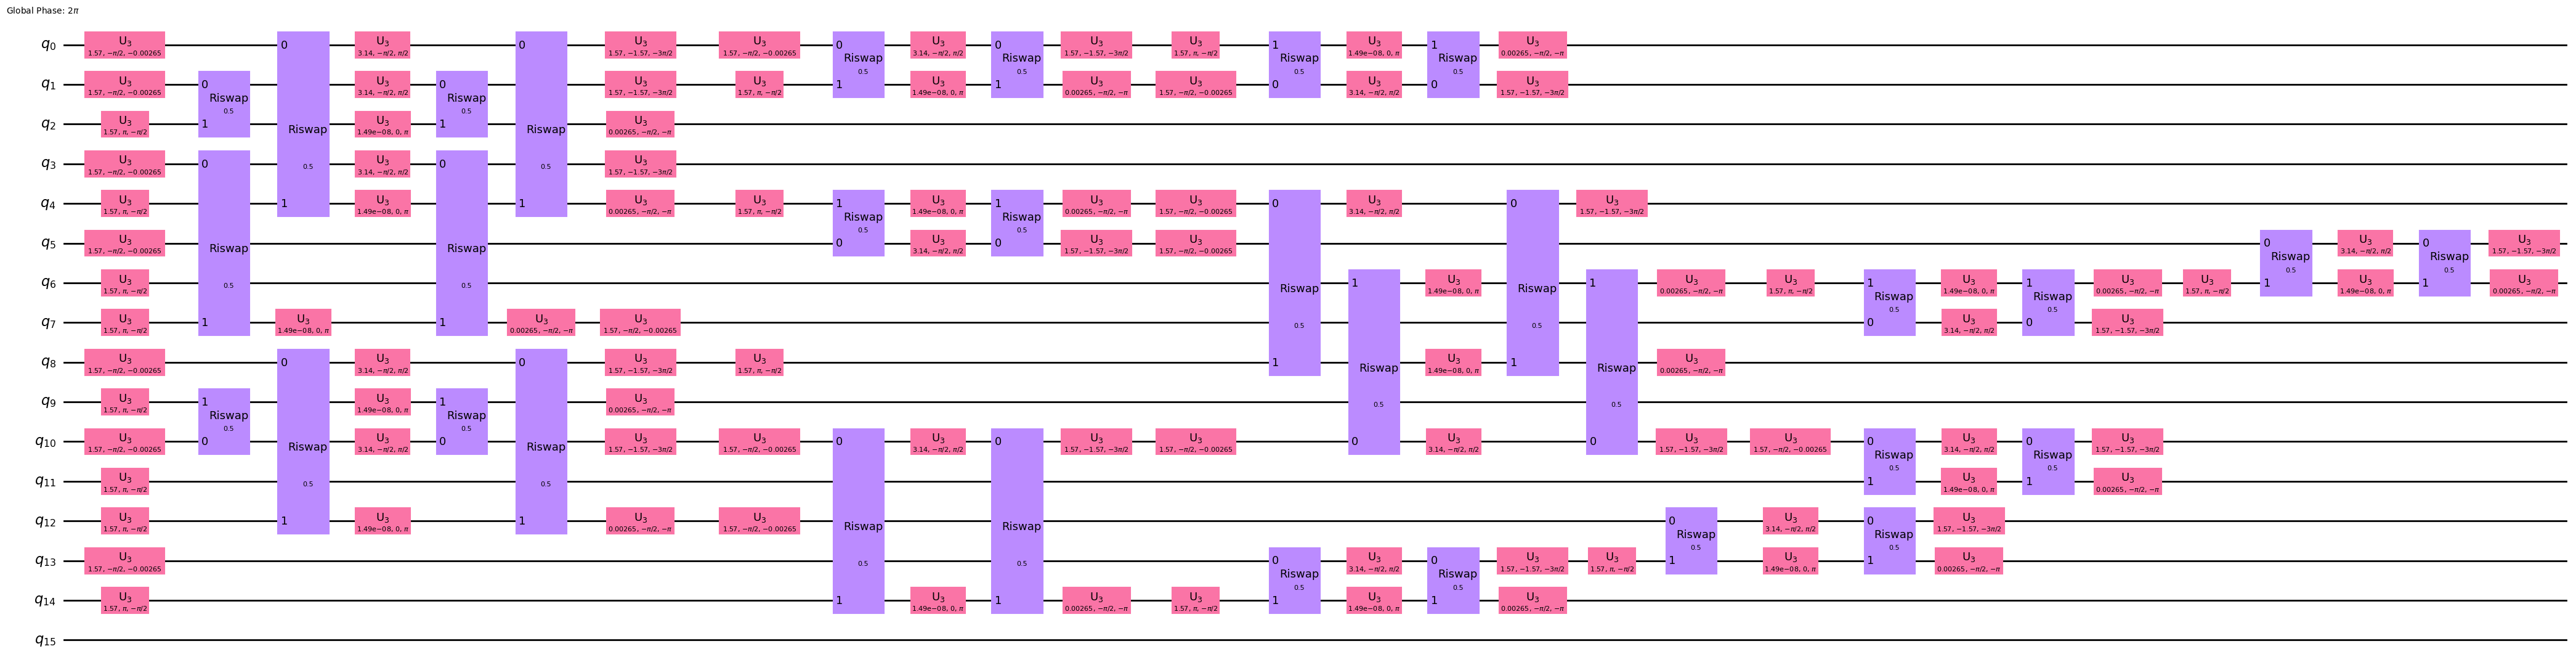

In [69]:
from qiskit import transpile

qc2 = transpile(qc, coupling_map=coupling, basis_gates=["cx", "u3"])
pm = PassManager([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
qc3 = pm.run(qc2)

# print(qc3.count_ops())
print(f"Gate count: {qc3.count_ops()['riswap']}")
# print(pm.property_set['count_ops_longest_path'])
# print(f"Depth: {qc3.depth()}")
print(
    f"Gate count critical path: {pm.property_set['count_ops_longest_path']['riswap']}"
)
qc3.draw(output='mpl', fold=-1)

In [70]:
# from virtual_swap.sqiswap_equiv import sel  # SessionEquivalenceLibrary

# qc4 = transpile(
#     qc, basis_gates=["u", "xx_plus_yy"], coupling_map=coupling, optimization_level=3
# )
# # bb.draw(output="mpl")

# pm = PassManager([CountOpsLongestPath()])
# qc4 = pm.run(qc4)

# print(f"Gate count: {qc4.count_ops()['xx_plus_yy']}")
# print(
#     f"Gate count critical path: {pm.property_set['count_ops_longest_path']['xx_plus_yy']}"
# )
# qc4.draw(output='mpl', fold=-1)

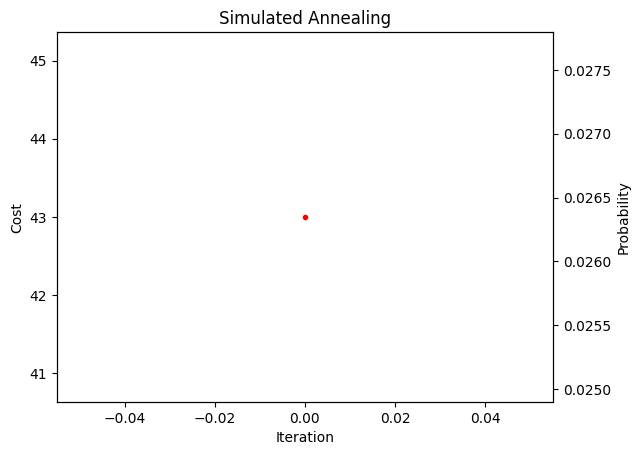

Cost: 47
Gate count: 96


KeyError: 'iswap'

In [74]:
from virtual_swap.vswap_simple import VirtualSwap
from qiskit.transpiler.passes import SabreLayout, SetLayout

# run the pass
pm = PassManager()
# need some basic unroll and layout
pm.append([Unroller(["u", "cx"]), SabreLayout(coupling), ApplyLayout()])
# pm.append([Unroller(["u", "cx"]), SetLayout(layout)])
pm.append(VirtualSwap(coupling, visualize=True, sa_params=(1.1, 10, 1)))
pm.append(OptimizeSwapBeforeMeasure())

# XXX use the PR version once merged into Qiskit
# pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
pm.append([CountOpsLongestPath()])

# set debug logging
# import logging

# logger = logging.getLogger("VSWAP")
# logger.setLevel(logging.INFO)

new_circ = pm.run(qc)

# sum the cost of gate 'cx' and 'iswap'
print(f"Gate count:", 2*new_circ.count_ops().get('iswap', 0) + 2*new_circ.count_ops()['cx'] + 3*new_circ.count_ops()['swap'])
longest_path = pm.property_set["count_ops_longest_path"]
print(f"Longest path gate count:", 2*longest_path['iswap'] + 2*longest_path['cx'] + 3*longest_path['swap'])

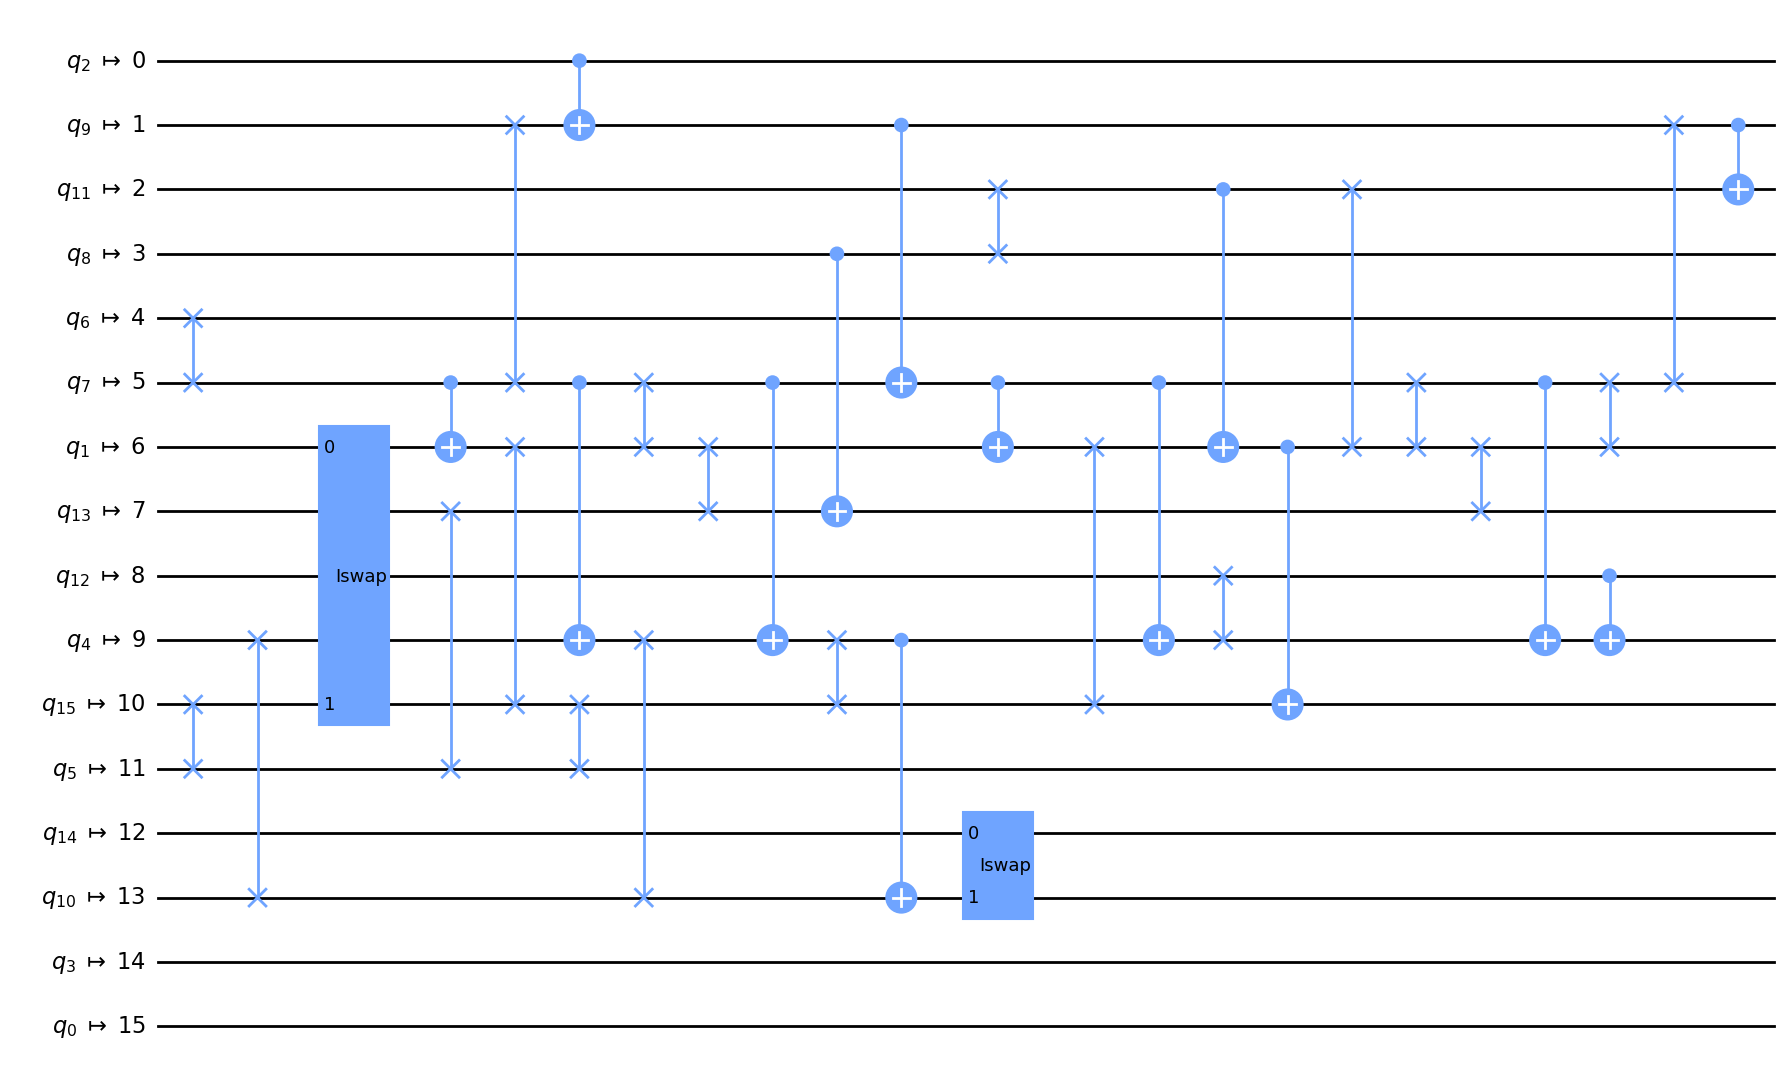

In [ ]:
new_circ.draw(output='mpl')

In [ ]:
# # run the pass
# pm = PassManager()
# # need some basic unroll and layout
# pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling), ApplyLayout()])
# pm.append(VirtualSwap(coupling, visualize=True))
# pm.append(OptimizeSwapBeforeMeasure())

# # XXX use the PR version once merged into Qiskit
# pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])

# # set debug logging
# # import logging

# # logger = logging.getLogger("VSWAP")
# # logger.setLevel(logging.INFO)

# new_circ = pm.run(qc)

# print(f"Gate count: {new_circ.count_ops()['riswap']}")
# print(
#     f"Gate count critical path: {pm.property_set['count_ops_longest_path']['riswap']}"
# )

In [ ]:
# # set up some simple loop to mess with cooling rate, find a rate that makes it actually converge to a minima
# # range of cooling_rates between .1 and .001, log scale
# # cooling_rate_list = np.logspace(-3, -1, 5)
# cooling_rate_list = [0.01, 0.01, 0.01]
# scores = []
# for cooling_rate in cooling_rate_list:
#     print(f"Cooling rate: {cooling_rate}")
#     pm = PassManager()
#     # need some basic unroll and layout
#     pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling), ApplyLayout()])
#     pm.append(VirtualSwap(coupling, sa_params=(5, cooling_rate, 1)))
#     pm.append(OptimizeSwapBeforeMeasure())
#     pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
#     new_circ = pm.run(qc)

#     print(f"Gate count: {new_circ.count_ops()['riswap']}")
#     print(
#         f"Gate count critical path: {pm.property_set['count_ops_longest_path']['riswap']}"
#     )
#     scores.append(pm.property_set["scores"])

In [ ]:
# import matplotlib.pyplot as plt

# for score, cooling_rate in zip(scores, cooling_rate_list):
#     plt.plot(score, "-.", label=f"cooling rate: {cooling_rate}")
# # x-axis log scale
# plt.xscale("log")
# plt.legend()

In [ ]:
# # set up some simple loop to mess with cooling rate, find a rate that makes it actually converge to a minima
# # range of cooling_rates between .1 and .001, log scale
# cooling_rate_list = np.logspace(-3, -1, 5)
# scores = []
# for cooling_rate in cooling_rate_list:
#     print(f"Cooling rate: {cooling_rate}")
#     pm = PassManager()
#     # need some basic unroll and layout
#     pm.append([Unroller(["u", "cx"]), TrivialLayout(coupling), ApplyLayout()])
#     pm.append(VirtualSwap(coupling, sa_params=(5, cooling_rate, 1)))
#     pm.append(OptimizeSwapBeforeMeasure())
#     pm.append([RootiSwapWeylDecomposition(), CountOpsLongestPath()])
#     new_circ = pm.run(qc)

#     print(f"Gate count: {new_circ.count_ops()['riswap']}")
#     print(
#         f"Gate count critical path: {pm.property_set['count_ops_longest_path']['riswap']}"
#     )
#     scores.append(pm.property_set["scores"])

Cooling rate: 0.001
Gate count: 86
Gate count critical path: 46
Cooling rate: 0.0031622776601683794
Gate count: 92
Gate count critical path: 35
Cooling rate: 0.01
Gate count: 92
Gate count critical path: 45
Cooling rate: 0.03162277660168379
Gate count: 86
Gate count critical path: 31
Cooling rate: 0.1
Gate count: 92
Gate count critical path: 51


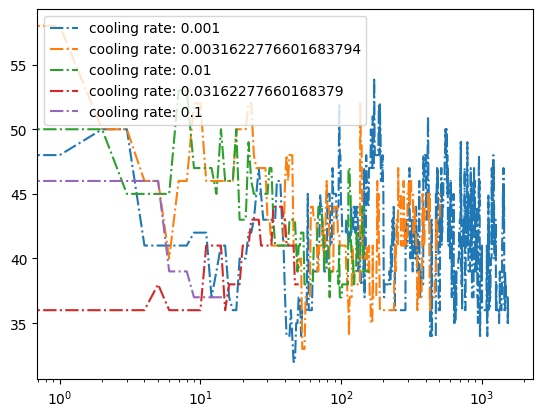

In [ ]:
# import matplotlib.pyplot as plt

# for score, cooling_rate in zip(scores, cooling_rate_list):
#     plt.plot(score, "-.", label=f"cooling rate: {cooling_rate}")
# # x-axis log scale
# plt.xscale("log")
# plt.legend()

In [ ]:
# # run the pass
# pm = PassManager()
# # need some basic unroll and layout
# routing_pass = VirtualSwap(coupling_map=coupling)
# pm.append(
#     [
#         Unroller(["u", "cx"]),
#         SabreLayout(coupling_map=coupling, routing_pass=routing_pass),
#         ApplyLayout(),
#     ]
# )
# pm.append(routing_pass)
# pm.append(OptimizeSwapBeforeMeasure())

# # XXX use the PR version once merged into Qiskit
# pm.append(RootiSwapWeylDecomposition())
# # set debug logging
# import logging

# logging.basicConfig(level=logging.INFO)
# new_circ = pm.run(qc)
# # new_circ.draw(output="mpl")
# print(f"Gate count: {new_circ.count_ops()['riswap']}")
# print(f"Depth: {new_circ.depth()}")

Gate count: 86
Depth: 110
